# VASP CdTe benchmark performance

This notebook compares the performance of the CdTe benchmark across different HPC facilities.

We compute the max time per SCF cycle from all cycles in the output file. Performance is plotted as SCF cycles per second (i.e. inverse of maximum SCF cycle time in seconds) 

## Setup section

Import the required modules and define useful functions.

In [7]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [8]:
import sys
sys.path.append('../../../python-modules')

In [9]:
from utilities import filemanip, sysinfo
from appanalysis import vasp

In [10]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

plotcores = False
unitlabel = "Nodes"
if plotcores:
    unitlabel = "Cores"

../../../python-modules/utilities/sysinfo.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  systems = yaml.load(input)


## Process data

In [11]:
systems = ['ARCHER','ARCHER2']
perf = {}
notes = {}
names = {}
nodes = {}
perf_max = {}
cpn = {}

for system in systems:
    wdir = '../CdTe_Hybrid/results/' + system
    filelist = filemanip.get_filelist(wdir, 'CdTe_')
    sysdict = sysdetails[system]
    names[system] = sysdict['Name']
    cpn[system] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(sysdict['Name'])
    vasp_df = pd.DataFrame(vasp.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode'], perftype="max"))
    nodes[system], perf_max[system] = vasp.get_perf_stats(vasp_df, 'max', writestats=True, plot_cores=plotcores)
    print('\n============================================================')


ARCHER
                                       Perf                                \
                                        min    median       max      mean   
Nodes Processes Threads NPAR KPAR                                           
8     192       1       8    2     0.000444  0.000444  0.000444  0.000444   
16    384       1       8    2     0.000272  0.000272  0.000272  0.000272   
32    768       1       8    2     0.000217  0.000217  0.000217  0.000217   

                                  Count  
                                    sum  
Nodes Processes Threads NPAR KPAR        
8     192       1       8    2        1  
16    384       1       8    2        1  
32    768       1       8    2        1  
           Perf                               Count
            min    median       max      mean   sum
Nodes                                              
8      0.000444  0.000444  0.000444  0.000444     1
16     0.000272  0.000272  0.000272  0.000272     1
32     0.000217  

## Performance Comparison

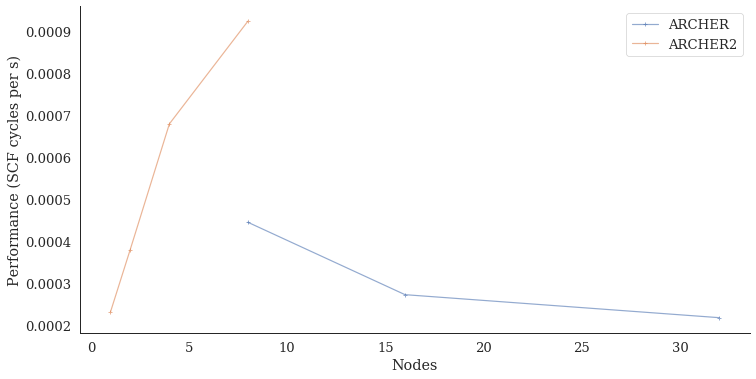

In [12]:
for system in systems:
    plt.plot(nodes[system], perf_max[system], '-+', label=names[system], alpha=0.6)
plt.xlabel(unitlabel)
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()